In [1]:
import logging
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%d-%b-%y %H:%M:%S',
                    level=logging.INFO
                   )

from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import gridspec
from matplotlib.ticker import ScalarFormatter
import matplotlib.font_manager as fm
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cmocean.cm as cmo
import cycler
import f90nml
import pvcalc

from dask.distributed import Client
from dask_jobqueue import SLURMCluster

In [2]:
base_path = Path('/work/n01/n01/fwg/irminger-proj')
raw_path = base_path / 'data/raw'
interim_path = base_path / 'data/interim'
processed_path = base_path / 'data/processed'
figure_path = base_path / 'figures/200m'
log_path = base_path / "src/post_processing/.tmp/log"
dask_worker_path = base_path / "src/post_processing/.tmp/"

env_path = base_path / "irminger-proj/bin/activate"


In [3]:
run_path = interim_path / "ensemble.zarr"
assert run_path.exists()
ds = xr.open_zarr(run_path)

data_nml = f90nml.read(raw_path / '2d-models/input_data_files_a/data')
delta_t = data_nml['parm03']['deltat']
f0 = ds.attrs['f0']
beta = ds.attrs['beta']
no_slip_bottom = ds.attrs['no_slip_bottom']
no_slip_sides = ds.attrs['no_slip_sides']

std_run = 32
logging.info(f"Standard run = {std_run}")
ds_std = ds.sel(run=std_run)

16-Mar-23 15:46:37 - Standard run = 32



logging.info("Setting plotting defaults")
logging.info('Setting plotting defaults')
fpath = Path('/home/n01/n01/fwg/.local/share/fonts/PTSans-Regular.ttf')
assert fpath.exists()
font_prop = fm.FontProperties(fname=fpath)
plt.rcParams['font.family'] = font_prop.get_family()
plt.rcParams['font.sans-serif'] = [font_prop.get_name()]

# font size
mpl.use("pgf")
plt.rc('xtick', labelsize='8')
plt.rc('ytick', labelsize='8')
plt.rcParams['axes.titlesize'] = 10
plt.rcParams["text.latex.preamble"] = "\\usepackage{euler} \\usepackage{paratype}  \\usepackage{mathfont} \\mathfont[digits]{PT Sans}"
plt.rcParams["pgf.preamble"] = plt.rcParams["text.latex.preamble"]
plt.rc('text', usetex=False)
# output
dpi = 600
text_width = 6


n = 6
color = cmo.dense(np.linspace(0, 1,n))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)


In [4]:
def prep_for_pv(ds):
    grid = pvcalc.create_xgcm_grid(ds)
    ds['drL'] = pvcalc.create_drL_from_dataset(ds)
    ds['rho'] = pvcalc.calculate_density(ds['RHOAnoma'], ds['rhoRef'])
    ds['b'] = pvcalc.calculate_buoyancy(ds['rho'])

    grad_b = pvcalc.calculate_grad_buoyancy(ds['b'], ds, grid)
    ds['db_dx'], ds['db_dy'], ds['db_dz'] = grad_b
    
    db_dz_mask = xr.where(grid.interp(ds['maskC'],
                                      ['Z'],
                                      to={'Z': 'right'},
                                      boundary='fill') == 0,
                          np.nan,
                          1)

    ds['db_dz'] = ds['db_dz'] * db_dz_mask

    curl_vel = pvcalc.calculate_curl_velocity(ds['UVEL'],
                                              ds['VVEL'],
                                              ds['WVEL'],
                                              ds,
                                              grid,no_slip_bottom,
                                              no_slip_sides)

    ds['zeta_x'], ds['zeta_y'], ds['zeta_z'] = curl_vel
    
    ds['NaNmaskC'] = xr.where(ds['maskC'] == 1, 1, np.NaN)
    
    ds['maskQ'] = grid.interp(ds['maskW'],
                              ['Y', 'Z'],
                              to={'Z': 'right', 'Y': 'left'},
                              boundary='fill')
    
    ds['NaNmaskQ'] = xr.where(ds['maskQ'] == 0, np.nan, 1)
    
    ds['Q'] = pvcalc.calculate_C_potential_vorticity(ds['zeta_x'],
                                                    ds['zeta_y'],
                                                    ds['zeta_z'],
                                                    ds['b'],
                                                    ds,
                                                    grid,
                                                    beta,
                                                    f0
                                                    ) * ds['NaNmaskQ']

    
    
    
    return ds, grid


def select_marker(wind_duration):
    if np.allclose(wind_duration, 1.08e5):
        marker, colour = "*", "tab:blue"
    elif np.allclose(wind_duration, 2.16e5):
        marker, colour = "o", "tab:orange"
    elif np.allclose(wind_duration, 3.24e5):
        marker, colour = "^", "tab:green"
    elif np.allclose(wind_duration, 4.32e5):
        marker, colour = "s", "tab:red"
    elif np.allclose(wind_duration, 0):
        marker, colour = "D", "black"
    else:
        raise ValueError("wind_duration not as expected")
    return marker, colour


In [5]:
rho_levels = np.array([1026.92, 1026.98, 1027.05, 1027.1211])


## Potential vorticity and stratification figures

Reference non-hydrostatic

Coarse 2D test (for supplementary materials)

### Reference hydrostatic (3D)
First we open the partial datasets from the raw files

In [6]:
try:
    scluster.close()
    client.close()
except:
    pass

logging.info("Launching cluster")
scluster = SLURMCluster(queue='standard',
                        account="n01-siAMOC",
                        job_cpu=256,
                        log_directory=log_path,
                        local_directory=dask_worker_path,
                        cores=24,
                        processes=24,  # Can change this
                        memory="256 GiB",
                        job_directives_skip= ['#SBATCH --mem='],  
                        walltime="00:10:00",
                        death_timeout=60,
                        interface='hsn0',
                        job_extra_directives=["--qos=standard", "--partition=standard"],
                        job_script_prologue=['module load cray-python',
                                'source {}'.format(str(env_path.absolute()))]
                    )


client = Client(scluster)
logging.info("Scaling cluster")
scluster.adapt(minimum_jobs=1, maximum_jobs=16,
               interval="1000 ms", wait_count=30)

16-Mar-23 15:46:37 - Launching cluster
16-Mar-23 15:46:42 - State start
16-Mar-23 15:46:42 -   Scheduler at:  tcp://10.253.23.31:39035
16-Mar-23 15:46:42 -   dashboard at:         10.253.23.31:8787
16-Mar-23 15:46:42 - Receive client connection: Client-bfc3b86a-c411-11ed-9c43-b42e99a23237
16-Mar-23 15:46:42 - Starting established connection to tcp://10.253.23.31:46208
16-Mar-23 15:46:42 - Scaling cluster
16-Mar-23 15:46:42 - Adaptive scaling started: minimum=24 maximum=384


Now we calculate the PV and N2 for the time-sliced dataset

In [8]:
def open_partial_daset(run):
    run_path = raw_path / "3d-models-200m" / run

    data_nml = f90nml.read(run_path /"data")
    delta_t = data_nml['parm03']['deltat']
    f0 = data_nml['parm01']['f0']
    beta = data_nml['parm01']['beta']
    no_slip_bottom = data_nml['parm01']['no_slip_bottom']
    no_slip_sides = data_nml['parm01']['no_slip_sides']

    from xmitgcm import open_mdsdataset
    ds_3d = open_mdsdataset(run_path,
                            prefix=['ZLevelVars', 'IntLevelVars'],
                            delta_t=delta_t,
                            geometry='cartesian',
                            #chunks=300
                            )

    ds_3d.attrs['f0'] = f0
    ds_3d.attrs['beta'] = beta
    ds_3d.attrs['no_slip_bottom'] = no_slip_bottom
    ds_3d.attrs['no_slip_sides'] = no_slip_sides
    return ds_3d



partial_control_datasets = [open_partial_daset(f"{letter}control") for letter in ["a", "b", "c", "d", "e"]]
full_control_dataset = xr.concat(partial_control_datasets, dim="time")
time_slice_3d_control = full_control_dataset.sel(time=[np.timedelta64(14, "D"), np.timedelta64(28, "D"), np.timedelta64(42, "D")], method="nearest")

partial_standard_datasets = [open_partial_daset(f"{letter}standard") for letter in ["a", "b", "c", "d", "e"]]
full_standard_dataset = xr.concat(partial_standard_datasets, dim="time")
time_slice_3d_standard = full_standard_dataset.sel(
    time=[np.timedelta64(14, "D"), np.tbimedelta64(28, "D"), np.timedelta64(42, "D")],
    method="nearest")


16-Mar-23 15:48:03 - Register worker <WorkerState 'tcp://10.253.19.251:36159', name: SLURMCluster-0-11, status: init, memory: 0, processing: 0>
16-Mar-23 15:48:03 - Starting worker compute stream, tcp://10.253.19.251:36159
16-Mar-23 15:48:03 - Starting established connection to tcp://10.253.19.251:51228
16-Mar-23 15:48:03 - Register worker <WorkerState 'tcp://10.253.19.251:40409', name: SLURMCluster-0-8, status: init, memory: 0, processing: 0>
16-Mar-23 15:48:03 - Starting worker compute stream, tcp://10.253.19.251:40409
16-Mar-23 15:48:03 - Starting established connection to tcp://10.253.19.251:51186
16-Mar-23 15:48:03 - Register worker <WorkerState 'tcp://10.253.19.251:38079', name: SLURMCluster-0-1, status: init, memory: 0, processing: 0>
16-Mar-23 15:48:03 - Starting worker compute stream, tcp://10.253.19.251:38079
16-Mar-23 15:48:03 - Starting established connection to tcp://10.253.19.251:51192
16-Mar-23 15:48:03 - Register worker <WorkerState 'tcp://10.253.19.251:37607', name: SL

In [ ]:
full_standard_dataset, grid = prep_for_pv(full_standard_dataset)
full_standard_dataset = full_standard_dataset.mean(dim=["YC", "YG"])
full_standard_dataset["db_dz"] = full_standard_dataset["db_dz"].compute()
full_standard_dataset["Q"] = full_standard_dataset["Q"].compute()
full_standard_dataset

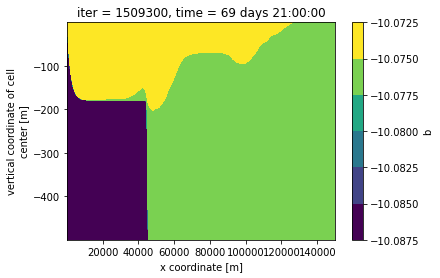

In [15]:
full_standard_dataset["b"].isel(time=-1).plot.contourf(robust=True)

In [26]:
time_slice_3d_control, grid = prep_for_pv(time_slice_3d_control)
time_slice_3d_control = time_slice_3d_control.mean(dim=["YC", "YG"])
time_slice_3d_control["db_dz"] = time_slice_3d_control["db_dz"].compute()
time_slice_3d_control["Q"] = time_slice_3d_control["Q"].compute()
time_slice_3d_control

<xarray.Dataset>
Dimensions:   (XC: 750, XG: 750, Z: 500, Zp1: 501, Zu: 500, Zl: 500, time: 3)
Coordinates: (12/13)
  * XC        (XC) >f4 100.0 300.0 500.0 700.0 ... 1.495e+05 1.497e+05 1.499e+05
  * XG        (XG) >f4 0.0 200.0 400.0 600.0 ... 1.494e+05 1.496e+05 1.498e+05
  * Z         (Z) >f4 -0.5 -1.5 -2.5 -3.5 -4.5 ... -496.5 -497.5 -498.5 -499.5
  * Zp1       (Zp1) >f4 0.0 -1.0 -2.0 -3.0 -4.0 ... -497.0 -498.0 -499.0 -500.0
  * Zu        (Zu) >f4 -1.0 -2.0 -3.0 -4.0 -5.0 ... -497.0 -498.0 -499.0 -500.0
  * Zl        (Zl) >f4 0.0 -1.0 -2.0 -3.0 -4.0 ... -496.0 -497.0 -498.0 -499.0
    ...        ...
    drF       (Z) >f4 dask.array<chunksize=(500,), meta=np.ndarray>
    PHrefC    (Z) >f4 dask.array<chunksize=(500,), meta=np.ndarray>
    PHrefF    (Zp1) >f4 dask.array<chunksize=(501,), meta=np.ndarray>
    rhoRef    (Z) >f4 dask.array<chunksize=(500,), meta=np.ndarray>
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) timedelta64[ns] 14 days 28 days 41 days 21:00:00
Data variables: (12/17)
    WVEL      (time, Zl, XC) float32 dask.array<chunksize=(1, 500, 750), meta=np.ndarray>
    UVEL      (time, Z, XG) float32 dask.array<chunksize=(1, 500, 750), meta=np.ndarray>
    VVEL      (time, Z, XC) float32 dask.array<chunksize=(1, 500, 750), meta=np.ndarray>
    RHOAnoma  (time, Z, XC) float32 dask.array<chunksize=(1, 500, 750), meta=np.ndarray>
    drL       (Zl) float32 dask.array<chunksize=(500,), meta=np.ndarray>
    rho       (time, Z, XC) float32 dask.array<chunksize=(1, 500, 750), meta=np.ndarray>
    ...        ...
    zeta_y    (time, Zl, XG) float32 dask.array<chunksize=(1, 499, 1), meta=np.ndarray>
    zeta_z    (time, Z, XG) float32 dask.array<chunksize=(1, 500, 1), meta=np.ndarray>
    NaNmaskC  (Z, XC) float64 nan 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    maskQ     (Zl, XG) float64 0.0 0.0 0.5 0.5 0.5 ... 0.25 0.25 0.25 0.25 0.25
    NaNmaskQ  (Zl, XG) float64 nan nan 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Q         (time, Zl, XG) float64 nan nan 6.82e-12 ... 8.436e-22 -8.229e-22

In [ ]:
time_slice_3d_standard, grid = prep_for_pv(time_slice_3d_standard)
time_slice_3d_standard = time_slice_3d_standard.mean(dim=["YC", "YG"])
time_slice_3d_standard["db_dz"] = time_slice_3d_standard["db_dz"].compute()
time_slice_3d_standard["Q"] = time_slice_3d_standard["Q"].compute()
time_slice_3d_standard

In [29]:
cmo.curl.set_bad("grey")
cmo.tarn.set_bad("grey")

In [40]:
fpath = Path('/home/n01/n01/fwg/.local/share/fonts/Arial.ttf')
assert fpath.exists()
font_prop = fm.FontProperties(fname=fpath)
plt.rcParams['font.family'] = font_prop.get_family()
plt.rcParams['font.sans-serif'] = [font_prop.get_name()]

# font size
plt.rc('xtick', labelsize='8')
plt.rc('ytick', labelsize='8')
plt.rcParams['axes.titlesize'] = 10
#plt.rcParams["text.latex.preamble"] = "\\usepackage{euler} \\usepackage{paratype}  \\usepackage{mathfont} \\mathfont[digits]{PT Sans}"
#plt.rcParams["pgf.preamble"] = plt.rcParams["text.latex.preamble"]
#plt.rc('text', usetex=False)
# output
dpi = 600
text_width = 6


n = 6
color = cmo.dense(np.linspace(0, 1,n))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)


def plot_pv_n2(time_slice_3d):
    fig = plt.figure(figsize=[6, 4])
    gs = gridspec.GridSpec(2, 4,
                           height_ratios=[1, 1],
                           width_ratios=[1, 1, 1, 1/14])

    pv_axs = [fig.add_subplot(gs[0, i]) for i in range(3)]
    n2_axs = [fig.add_subplot(gs[1, i]) for i in range(3)]


    for i in range(3):
        cpv = pv_axs[i].pcolormesh(
            time_slice_3d["XG"] * 1e-3,
            -time_slice_3d["Zl"],
            time_slice_3d["Q"].isel(time=i),
            cmap=cmo.curl,
            vmin=-2e-9,
            vmax=2e-9
        )

        pv_axs[i].set_ylim(250, 0)
        pv_axs[i].set_xlim(0, 100)

        pv_axs[i].set_xticklabels([])

        if i == 0: week = "weeks"
        else: week = "weeks"

        pv_axs[i].set_title(f"{(i + 1) * 2} {week}")

        pv_labels = ["(a)", "(b)", "(c)"]
        pv_axs[i].set_title(pv_labels[i], loc="left")

        cn2 = n2_axs[i].pcolormesh(
            time_slice_3d["XC"] * 1e-3,
            -time_slice_3d["Zl"],
            time_slice_3d["db_dz"].isel(time=i),
            cmap=cmo.tarn,
            vmin=-1e-5,
            vmax=1e-5,
        )

        n2_axs[i].set_ylim(250, 0)
        n2_axs[i].set_xlim(0, 100)

        n2_labels = ["(d)", "(e)", "(f)"]
        n2_axs[i].set_title(n2_labels[i], loc="left")

    for i in range(1, 3):
        pv_axs[i].set_yticklabels([])
        n2_axs[i].set_yticklabels([])

    pv_cbax = fig.add_subplot(gs[0, 3])
    n2_cbax = fig.add_subplot(gs[1, 3])

    fmt = ScalarFormatter(useMathText=True)
    pv_cb = fig.colorbar(cpv, pv_cbax, label="$Q$ (s$^{-3}$)", format=fmt)
    n2_cb = fig.colorbar(cn2, n2_cbax, label="$\\partial_z b$ (s$^{-2}$)", format=fmt)

    fig.supxlabel("Longitude (km)")
    fig.supylabel("Depth (m)")
    fig.suptitle("Standard 3D")


    fig.tight_layout()
    


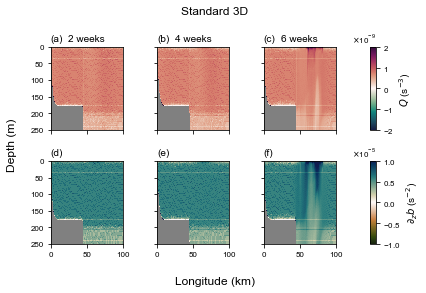

In [41]:
plot_pv_n2(time_slice_3d_control)

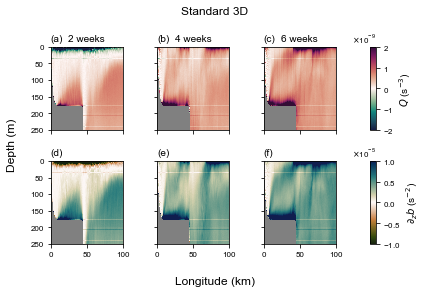

In [42]:
plot_pv_n2(time_slice_3d_standard)

## Mixed layer depth changes
First we open the processed 2D mixed layer depths

In [10]:
ensemble_path = interim_path / "ensemble.zarr"
mld_path = processed_path / "mld.zarr"

ds_ensemble = xr.open_zarr(ensemble_path)
ds_mld = xr.open_zarr(mld_path).squeeze()

Now we calculate the mixed layer depth from the raw 3D model data

In [ ]:
ds_mld_3d = full_dataset.sel(time=[0, np.timedelta64(21, "D")], method="nearest")
ds_mld_3d["rho"] = pvcalc.calculate_density(ds_mld_3d["RHOAnoma"], ds_mld_3d["rhoRef"])

delta_rho = 0.05
attrs = {'delta_rho': delta_rho,
         'delta_rho_units': 'kg m-3'}

da_delta_rho_surf = ds_mld_3d['rho'] - ds_mld_3d['rho'].isel(Z=0)
delta_rho_drop = da_delta_rho_surf.where(lambda x: x<= delta_rho).idxmax('Z')
delta_rho_drop = delta_rho_drop.compute()

delta_mld_3d = (delta_rho_drop.isel(time=0) - delta_rho_drop.isel(time=-1)).mean(["XC", "YC"])

10-Mar-23 14:28:46 - Event loop was unresponsive in Scheduler for 3.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


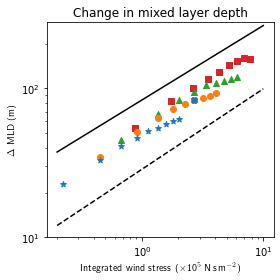

In [37]:
from scipy.special import erf
days = 24 * 60 * 60

ds_mld = ds_mld.assign_coords({"wind_stress": ds_ensemble["wind_stress"],
                                "wind_duration": ds_ensemble["wind_duration"]})

ds_mld["tau_int"] = np.sqrt(2 * np.pi) \
                    * ds_mld["wind_stress"] * ds_mld["wind_duration"] \
                    * erf(10.5 * days / np.sqrt(2) \
                    / ds_mld["wind_duration"].compute()) * 1e-5

delta_mld = ds_mld["mn_drop_depth"].isel(time=0) - ds_mld["mn_drop_depth"].isel(time=-1)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for run in ds_mld['run']:
    marker, colour = select_marker(ds_ensemble["wind_duration"].sel(run=run))
    
    ax.scatter(-ds_mld["tau_int"].sel(run=run),
                delta_mld.sel(run=run),
                marker=marker,
                color=colour)   

ax.scatter(-ds_mld["tau_int"].sel(run=32),
           delta_mld_3d,
           marker="X")

ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0), useMathText=True)

ti = np.linspace(0.2, 10)
ax.plot(ti, (ti*7000) ** 0.5, c="k", label="$\\tau_{int}^{0.5}$")
ax.plot(ti, (ti*500) ** 0.54, c="k", ls="--", label="$\\tau_{int}^{0.54}$")
ax.set_ylim(10, None)

ax.set_xscale("log")
ax.set_yscale("log")

ax.scatter(None, None, marker="D", color="black", label=0)
ax.scatter(None, None, marker="*", color="tab:blue", label=1.08e5 / days)
ax.scatter(None, None, marker="o", color="tab:orange", label=2.16e5 / days)
ax.scatter(None, None, marker="^", color="tab:green", label=3.24e5 / days)
ax.scatter(None, None, marker="s", color="tab:red", label=4.32e5 / days)
    
ax.set_xlabel("Integrated wind stress ($\\times$10$^{5}$ N$\\,$s$\\,$m$^{-2}$)", usetex=True)
ax.set_ylabel("$\Delta$ MLD (m)", usetex=True)
ax.set_title("Change in mixed layer depth")
#ax.legend(title="Wind event duration (days)")

fig.tight_layout()


## Water mass transformations

In [8]:
ds_trans_2d = xr.open_dataarray(processed_path / "Transformation.nc")
ds_trans_2d["rho_centre"] = 0.5 * (ds_trans_2d["rho_upper"] + ds_trans_2d["rho_lower"])
ds_trans_2d

<xarray.DataArray (run: 37, classs: 131)>
[4847 values with dtype=float64]
Coordinates:
  * classs      (classs) int64 0 1 2 3 4 5 6 7 ... 124 125 126 127 128 129 130
    rho_upper   (classs) float64 0.0 1.027e+03 1.027e+03 ... 1.027e+03 1.027e+03
    rho_lower   (classs) float64 1.027e+03 1.027e+03 1.027e+03 ... 1.027e+03 inf
    YC          float32 12.5
    YG          float32 0.0
  * run         (run) int64 0 6 7 8 9 11 12 13 14 ... 39 41 42 43 44 46 47 48 49
    rho_centre  (classs) float64 513.4 1.027e+03 1.027e+03 ... 1.027e+03 inf

In [39]:
try:
    scluster.close()
    client.close()
except:
    pass

scluster = SLURMCluster(queue='standard',
                        account="n01-siAMOC",
                        job_cpu=256,
                        log_directory=log_path,
                        local_directory=dask_worker_path,
                        cores=24,
                        processes=24,  # Can change this
                        memory="256 GiB",
                        job_directives_skip= ['#SBATCH --mem='],  
                        walltime="00:10:00",
                        death_timeout=60,
                        interface='hsn0',
                        job_extra_directives=["--qos=standard", "--partition=standard"],
                        job_script_prologue=['module load cray-python',
                                'source {}'.format(str(env_path.absolute()))]
                    )


client = Client(scluster)
logging.info("Scaling cluster")
scluster.adapt(minimum_jobs=1, maximum_jobs=16,
               interval="1000 ms", wait_count=30)

10-Mar-23 15:40:19 - Adaptive stop
10-Mar-23 15:40:19 - Scheduler closing...
10-Mar-23 15:40:19 - Scheduler closing all comms
10-Mar-23 15:40:19 - Adaptive stop
/mnt/lustre/a2fs-work1/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34267 instead
  warnings.warn(
10-Mar-23 15:40:19 - State start
10-Mar-23 15:40:19 -   Scheduler at: tcp://10.253.16.177:34689
10-Mar-23 15:40:19 -   dashboard at:       10.253.16.177:34267
10-Mar-23 15:40:19 - Receive client connection: Client-dd02ba20-bf59-11ed-b08a-b42e99a2321b
10-Mar-23 15:40:19 - Starting established connection to tcp://10.253.16.177:57384
10-Mar-23 15:40:19 - Scaling cluster
10-Mar-23 15:40:19 - Adaptive scaling started: minimum=24 maximum=384


In [16]:
full_dataset

<xarray.Dataset>
Dimensions:   (XC: 750, YC: 250, XG: 750, YG: 250, Z: 500, Zp1: 501, Zu: 500,
               Zl: 500, time: 168)
Coordinates: (12/34)
  * XC        (XC) >f4 100.0 300.0 500.0 700.0 ... 1.495e+05 1.497e+05 1.499e+05
  * YC        (YC) >f4 100.0 300.0 500.0 700.0 ... 4.95e+04 4.97e+04 4.99e+04
  * XG        (XG) >f4 0.0 200.0 400.0 600.0 ... 1.494e+05 1.496e+05 1.498e+05
  * YG        (YG) >f4 0.0 200.0 400.0 600.0 ... 4.94e+04 4.96e+04 4.98e+04
  * Z         (Z) >f4 -0.5 -1.5 -2.5 -3.5 -4.5 ... -496.5 -497.5 -498.5 -499.5
  * Zp1       (Zp1) >f4 0.0 -1.0 -2.0 -3.0 -4.0 ... -497.0 -498.0 -499.0 -500.0
    ...        ...
    dyF       (YC, XC) >f4 200.0 200.0 200.0 200.0 ... 200.0 200.0 200.0 200.0
    dxF       (YC, XC) >f4 200.0 200.0 200.0 200.0 ... 200.0 200.0 200.0 200.0
    dxV       (YG, XG) >f4 200.0 200.0 200.0 200.0 ... 200.0 200.0 200.0 200.0
    rhoRef    (Z) >f4 dask.array<chunksize=(500,), meta=np.ndarray>
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) timedelta64[ns] 0 days 00:00:00 ... 20 days 21:00:00
Data variables:
    WVEL      (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 500, 250, 750), meta=np.ndarray>
    UVEL      (time, Z, YC, XG) float32 dask.array<chunksize=(1, 500, 250, 750), meta=np.ndarray>
    VVEL      (time, Z, YG, XC) float32 dask.array<chunksize=(1, 500, 250, 750), meta=np.ndarray>
    RHOAnoma  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 500, 250, 750), meta=np.ndarray>
    TOTTTEND  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 500, 250, 750), meta=np.ndarray>
Attributes:
    Conventions:     CF-1.6
    title:           netCDF wrapper of MITgcm MDS binary data
    source:          MITgcm
    history:         Created by calling `open_mdsdataset(grid_dir=None, iters...
    f0:              0.000126
    beta:            0.0
    no_slip_bottom:  False
    no_slip_sides:   False

In [40]:
ds = full_dataset.isel(time=[0, -1])
ds["rho"] = pvcalc.calculate_density(ds["RHOAnoma"], ds["rhoRef"])

density_class_boundaries = np.linspace(1026.8, 1027.25, 130)
assert np.all(np.diff(density_class_boundaries) > 0)


class_coords = {'classs': ('classs',
                           range(0, len(density_class_boundaries) + 1)),
                
                'rho_upper': ('classs',
                              np.insert(density_class_boundaries, 0, 0)),
                
                'rho_lower': ('classs',
                              np.append(density_class_boundaries, np.inf)),
                
                'XC': ds['XC'],
                'XG': ds['XG'],
                'YC': ds['YC'],
                'YG': ds['YG'],
                'Z': ds['Z'],
                'Zl': ds['Zl'],
                'Zu': ds['Zu'],
                'Zp1': ds['Zp1'],}

In [52]:
ds["dVOL"] = ds["rA"] * ds["drF"]

nclass, nt = 131, 2
volume_array = np.empty((nclass, nt))

for classs in range(nclass):
    print(classs)
    mask1 = xr.where(
        ds['rho'] <= ds_class['rho_lower'].isel(classs=classs),
        True,
        False
    ) 
    
    mask2 = xr.where(
        ds['rho'] > ds_class['rho_upper'].isel(classs=classs),
        True,
        False
    )

    volume = (mask1 * mask2 * ds["dVOL"]).sum(["Z", "YC", "XC"])
    
    
    volume_array[classs, :] = volume.compute()


In [54]:
ds_class

<xarray.Dataset>
Dimensions:    (classs: 131, XC: 750, XG: 750, YC: 250, YG: 250, Z: 500,
                Zl: 500, Zu: 500, Zp1: 501)
Coordinates:
  * classs     (classs) int64 0 1 2 3 4 5 6 7 ... 124 125 126 127 128 129 130
    rho_upper  (classs) float64 0.0 1.027e+03 1.027e+03 ... 1.027e+03 1.027e+03
    rho_lower  (classs) float64 1.027e+03 1.027e+03 1.027e+03 ... 1.027e+03 inf
  * XC         (XC) >f4 100.0 300.0 500.0 ... 1.495e+05 1.497e+05 1.499e+05
  * XG         (XG) >f4 0.0 200.0 400.0 600.0 ... 1.494e+05 1.496e+05 1.498e+05
  * YC         (YC) >f4 100.0 300.0 500.0 700.0 ... 4.95e+04 4.97e+04 4.99e+04
  * YG         (YG) >f4 0.0 200.0 400.0 600.0 ... 4.94e+04 4.96e+04 4.98e+04
  * Z          (Z) >f4 -0.5 -1.5 -2.5 -3.5 -4.5 ... -496.5 -497.5 -498.5 -499.5
  * Zl         (Zl) >f4 0.0 -1.0 -2.0 -3.0 -4.0 ... -496.0 -497.0 -498.0 -499.0
  * Zu         (Zu) >f4 -1.0 -2.0 -3.0 -4.0 -5.0 ... -497.0 -498.0 -499.0 -500.0
  * Zp1        (Zp1) >f4 0.0 -1.0 -2.0 -3.0 -4.0 ... -497.0 -498.0 -499.0 -500.0
Data variables:
    *empty*

In [80]:
ds["dVOL"]

<xarray.DataArray 'dVOL' (YC: 250, XC: 750, Z: 500)>
dask.array<multiply, shape=(250, 750, 500), dtype=float32, chunksize=(250, 750, 500), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) >f4 100.0 300.0 500.0 700.0 ... 1.495e+05 1.497e+05 1.499e+05
  * YC       (YC) >f4 100.0 300.0 500.0 700.0 ... 4.95e+04 4.97e+04 4.99e+04
  * Z        (Z) >f4 -0.5 -1.5 -2.5 -3.5 -4.5 ... -496.5 -497.5 -498.5 -499.5
    rA       (YC, XC) >f4 4e+04 4e+04 4e+04 4e+04 ... 4e+04 4e+04 4e+04 4e+04
    Depth    (YC, XC) >f4 0.0 17.0 33.0 47.0 59.0 ... 500.0 500.0 500.0 500.0
    drF      (Z) >f4 dask.array<chunksize=(500,), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(500,), meta=np.ndarray>
    hFacC    (Z, YC, XC) >f4 0.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    maskC    (Z, YC, XC) bool False True True True True ... True True True True
    dyF      (YC, XC) >f4 200.0 200.0 200.0 200.0 ... 200.0 200.0 200.0 200.0
    dxF      (YC, XC) >f4 200.0 200.0 200.0 200.0 ... 200.0 200.0 200.0 200.0
    rhoRef   (Z) >f4 dask.array<chunksize=(500,), meta=np.ndarray>

In [64]:
ds_class = xr.Dataset(coords=class_coords)
ds_class["time"] = ds["time"]
ds_class["vol"] = (("classs", "time"), volume_array)
dvol_dt = ds_class["vol"].diff("time") / (ds_class["time"].diff("time").astype(float) * 1e-9)
dvol_dt = dvol_dt.squeeze()


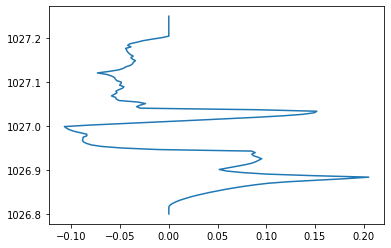

In [85]:
plt.plot(-dvol_dt.cumsum(dim="classs") * 1e-6 / 50e3 * 200e3, ds_trans_2d["rho_lower"])

## Surface vorticity

In [14]:
from xmitgcm import open_mdsdataset

In [128]:
control_path = raw_path / "3d-models-200m/ccontrol"
assert control_path.exists()

standard_path = raw_path / "3d-models-200m/bstandard"
assert standard_path.exists()

data_nml = f90nml.read(control_path /"data")
delta_t = data_nml['parm03']['deltat']
f0 = data_nml['parm01']['f0']
beta = data_nml['parm01']['beta']
no_slip_bottom = data_nml['parm01']['no_slip_bottom']
no_slip_sides = data_nml['parm01']['no_slip_sides']

In [124]:
import pvcalc

In [129]:
ds_control = open_mdsdataset(
    control_path, 
    prefix=["ZLevelVars"],
    delta_t=delta_t,
    geometry='cartesian',
    iters=[904500],
               )

ds_standard = open_mdsdataset(
    standard_path, 
    prefix=["ZLevelVars"],
    delta_t=delta_t,
    geometry='cartesian',
    iters=[602100],
               )

In [130]:
def curl_velocity(ds):
    grid = pvcalc.create_xgcm_grid(ds)
    ds['drL'] = pvcalc.create_drL_from_dataset(ds)

    curl_vel = pvcalc.calculate_curl_velocity(ds['UVEL'],
                                              ds['VVEL'],
                                              ds['Zl'] * ds["rA"],
                                              ds,
                                              grid,no_slip_bottom,
                                              no_slip_sides)

    ds['zeta_x'], ds['zeta_y'], ds['zeta_z'] = curl_vel
    return ds["zeta_z"]

In [131]:
ds_control

<xarray.Dataset>
Dimensions:   (time: 1, XC: 750, YC: 250, XG: 750, YG: 250, Z: 500, Zp1: 501,
               Zu: 500, Zl: 500)
Coordinates: (12/34)
    iter      (time) int64 904500
  * time      (time) timedelta64[ns] 41 days 21:00:00
  * XC        (XC) >f4 100.0 300.0 500.0 700.0 ... 1.495e+05 1.497e+05 1.499e+05
  * YC        (YC) >f4 100.0 300.0 500.0 700.0 ... 4.95e+04 4.97e+04 4.99e+04
  * XG        (XG) >f4 0.0 200.0 400.0 600.0 ... 1.494e+05 1.496e+05 1.498e+05
  * YG        (YG) >f4 0.0 200.0 400.0 600.0 ... 4.94e+04 4.96e+04 4.98e+04
    ...        ...
    maskS     (Z, YG, XC) bool dask.array<chunksize=(500, 250, 750), meta=np.ndarray>
    dyU       (YG, XG) >f4 dask.array<chunksize=(250, 750), meta=np.ndarray>
    dyF       (YC, XC) >f4 dask.array<chunksize=(250, 750), meta=np.ndarray>
    dxF       (YC, XC) >f4 dask.array<chunksize=(250, 750), meta=np.ndarray>
    dxV       (YG, XG) >f4 dask.array<chunksize=(250, 750), meta=np.ndarray>
    rhoRef    (Z) >f4 1.027e+03 1.027e+03 1.027e+03 ... 1.027e+03 1.027e+03
Data variables:
    UVEL      (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 500, 250, 750), meta=np.ndarray>
    VVEL      (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 500, 250, 750), meta=np.ndarray>
    RHOAnoma  (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 500, 250, 750), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=[9...

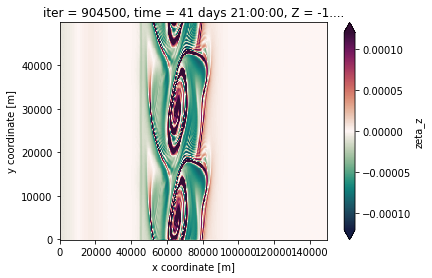

In [134]:
vort = curl_velocity(ds_control).isel(Z=1)
vort.plot(robust=True, cmap=cmo.curl)

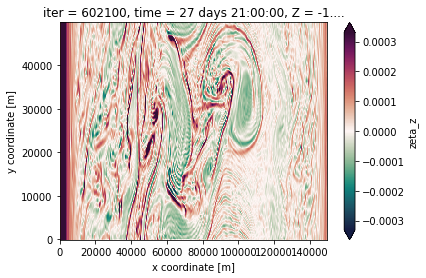

In [137]:
vort = curl_velocity(ds_standard).isel(Z=1)
vort.plot(robust=True, cmap=cmo.curl)

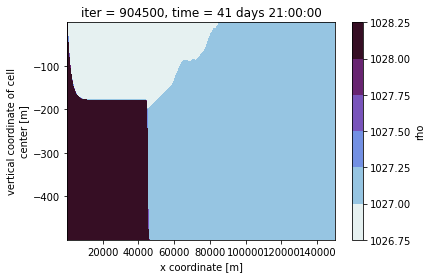

In [135]:
ds_control['rho'] = pvcalc.calculate_density(ds_control['RHOAnoma'], ds_control['rhoRef'])
ds_control["rho"].mean(dim="YC").squeeze().plot.contourf(robust=True, cmap=cmo.dense)

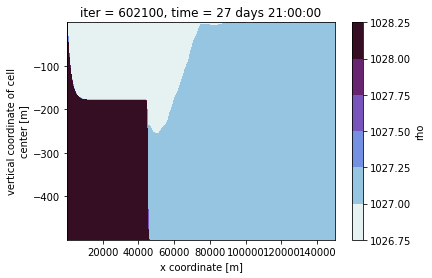

In [71]:
ds_standard['rho'] = pvcalc.calculate_density(ds_standard['RHOAnoma'], ds_standard['rhoRef'])
ds_standard["rho"].mean(dim="YC").squeeze().plot.contourf(robust=True, cmap=cmo.dense)

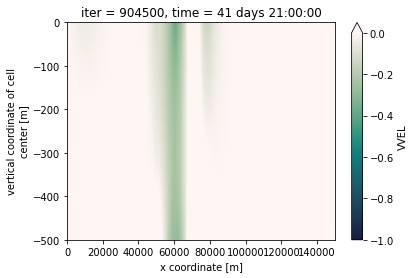

In [136]:
ds_control["VVEL"].mean(dim="YG").plot(robust=True, vmin=-1, vmax=0, cmap=cmo.tempo_r)

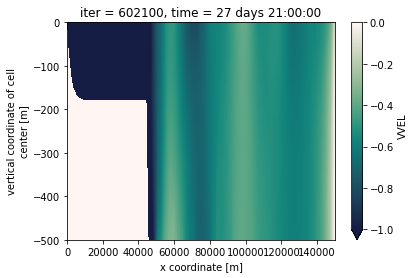

In [86]:
ds_standard["VVEL"].mean(dim="YG").plot(robust=True, vmin=-1, vmax=0, cmap=cmo.tempo_r)

## Eddy kinetic energy

In [87]:
control_path = raw_path / "3d-models-200m/bcontrol"
assert control_path.exists()

standard_path = raw_path / "3d-models-200m/bstandard"
assert standard_path.exists()

data_nml = f90nml.read(control_path /"data")
delta_t = data_nml['parm03']['deltat']
f0 = data_nml['parm01']['f0']
beta = data_nml['parm01']['beta']
no_slip_bottom = data_nml['parm01']['no_slip_bottom']
no_slip_sides = data_nml['parm01']['no_slip_sides']

In [92]:
ds_standard = open_mdsdataset(
    standard_path, 
    prefix=["EddyKineticEnergy"],
    delta_t=delta_t,
    geometry='cartesian',
    iters="all",
               )

In [99]:
ds_standard

<xarray.Dataset>
Dimensions:   (XC: 750, YC: 250, XG: 750, YG: 250, Z: 500, Zp1: 501, Zu: 500,
               Zl: 500, time: 4)
Coordinates: (12/34)
  * XC        (XC) >f4 100.0 300.0 500.0 700.0 ... 1.495e+05 1.497e+05 1.499e+05
  * YC        (YC) >f4 100.0 300.0 500.0 700.0 ... 4.95e+04 4.97e+04 4.99e+04
  * XG        (XG) >f4 0.0 200.0 400.0 600.0 ... 1.494e+05 1.496e+05 1.498e+05
  * YG        (YG) >f4 0.0 200.0 400.0 600.0 ... 4.94e+04 4.96e+04 4.98e+04
  * Z         (Z) >f4 -0.5 -1.5 -2.5 -3.5 -4.5 ... -496.5 -497.5 -498.5 -499.5
  * Zp1       (Zp1) >f4 0.0 -1.0 -2.0 -3.0 -4.0 ... -497.0 -498.0 -499.0 -500.0
    ...        ...
    dyF       (YC, XC) >f4 dask.array<chunksize=(250, 750), meta=np.ndarray>
    dxF       (YC, XC) >f4 dask.array<chunksize=(250, 750), meta=np.ndarray>
    dxV       (YG, XG) >f4 dask.array<chunksize=(250, 750), meta=np.ndarray>
    rhoRef    (Z) >f4 dask.array<chunksize=(500,), meta=np.ndarray>
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) timedelta64[ns] 16 days 20 days 24 days 28 days
Data variables:
    momKE     (time, YC, XC) float32 dask.array<chunksize=(1, 250, 750), meta=np.ndarray>
    UE_VEL_C  (time, YC, XC) float32 dask.array<chunksize=(1, 250, 750), meta=np.ndarray>
    VN_VEL_C  (time, YC, XC) float32 dask.array<chunksize=(1, 250, 750), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...

In [111]:
tot_ke = (ds_standard.momKE / ds_standard["Depth"]).sum(dim=["XC", "YC"])

In [112]:
lam_ke = 0.5 * (np.square(ds_standard["UE_VEL_C"]) + np.square(ds_standard["VN_VEL_C"])).sum(dim=["XC", "YC"])

In [113]:
turb_ke = tot_ke - lam_ke

/mnt/lustre/a2fs-work1/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


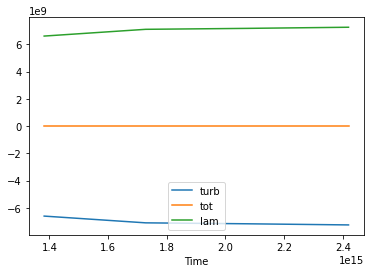

In [114]:
turb_ke.plot(label="turb")
tot_ke.plot(label="tot")
lam_ke.plot(label="lam")
plt.legend()

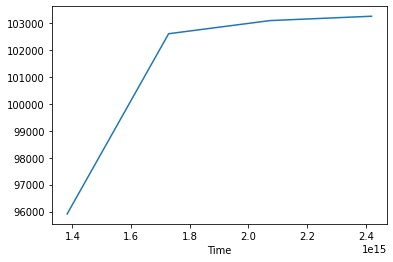

In [115]:
tot_ke.plot()